# 🧠 SSVEP BCI Tutorial: A 12-Class Prediction for a Virtual Keypad

Prepared by Nona Rajabi and Abdulkadir Gokce, November 2025.

This tutorial walks you through an example of an SSVEP (Steady-State Visually Evoked Potential) pipeline:

1. Task & biomarkers (what are we decoding?)
2. Dataset (MATLAB → NumPy arrays)
3. Preprocessing (filtering, epoching)
4. Visualization (raw traces, PSD)
5. CCA-based decoding
6. EEGNet (deep learning baseline)

# 1) Task & Biomarkers

**SSVEP (Steady-State Visually Evoked Potential)** is an oscillatory EEG response elicited when a person looks at a flickering visual stimulus.  

**Task:** Given multi-channel EEG, identify which stimulus (i.e., which flicker frequency) the participant attended.

**Key biomarkers:**
- **Frequency-locked power peaks** at the **stimulation frequency** *(f0)* and its **harmonics** *(2f0, 3f0, ...)* in the EEG spectrum.

- Largest SSVEP amplitudes are typically over **occipital** electrodes (e.g., O1/Oz/O2), but this can vary across subjects and setups.

We'll use two families of models:
- **CCA (Canonical Correlation Analysis):** correlates EEG with reference sinusoids at candidate frequencies (and harmonics), selecting the class with highest correlation.
- **EEGNet:** a compact CNN designed for EEG decoding, used here as a deep learning baseline.

# 2) Dataset

We will use the SSVEP dataset from Nakanishi et al. [1], recorded from ten participants (nine males; mean age = 28 years). During each recording session, participants gazed at a virtual keypad displayed on a screen. The keypad consisted of 12 targets arranged in a 4 × 3 grid, with each target flickering at a unique frequency and phase to elicit steady-state visual evoked potentials (SSVEPs). The stimulus frequencies ranged from f₀ = 9.25 Hz with increments of Δf = 0.5 Hz, and the corresponding phases were offset by ∅₀ = 0 with increments of Δ∅ = 0.5π.

![image.png](https://cdn.ncbi.nlm.nih.gov/pmc/blobs/13d9/4610694/b1bd7db58a64/pone.0140703.g001.jpg)


[1] Nakanishi, Masaki, et al. "A comparison study of canonical correlation analysis based methods for detecting steady-state visual evoked potentials." PloS one 10.10 (2015): e0140703.

### Download the data

In [ ]:
!mkdir -p data
!curl -O https://sccn.ucsd.edu/download/cca_ssvep.zip
!unzip cca_ssvep.zip -d temp
!mv temp/cca_ssvep/* data/
!rm -rf temp
!rm cca_ssvep.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  145M  100  145M    0     0  72.1M      0  0:00:02  0:00:02 --:--:-- 72.1M
Archive:  cca_ssvep.zip
   creating: temp/cca_ssvep/
  inflating: temp/cca_ssvep/s4.mat   
  inflating: temp/cca_ssvep/s5.mat   
  inflating: temp/cca_ssvep/s3.mat   
  inflating: temp/cca_ssvep/s7.mat   
  inflating: temp/cca_ssvep/chan_locs.pdf  
  inflating: temp/cca_ssvep/readme.txt  
  inflating: temp/cca_ssvep/s2.mat   
  inflating: temp/cca_ssvep/s8.mat   
  inflating: temp/cca_ssvep/s10.mat  
  inflating: temp/cca_ssvep/s9.mat   
  inflating: temp/cca_ssvep/s6.mat   
  inflating: temp/cca_ssvep/s1.mat   


In [ ]:
from pathlib import Path
import numpy as np

# -------------------------
# User-configurable options
# -------------------------
DATA_DIR = Path("./data")            # Folder containing your .mat file(s)
MAT_FILE = "/content/data/s8.mat"    # e.g., Path("./data/subject01_ssvep.mat")
SAMPLING_RATE = 256                  # Hz; used for synthetic data fallback and checks
CHANNEL_NAMES = None                 # If your data has known channel names, set a list here
STIM_FREQS = [9.25, 11.25, 13.25,
              9.75, 11.75, 13.75,
              10.25, 12.25, 14.25,
              10.75, 12.75, 14.75]   # Candidate flicker frequencies (Hz)
PHASES = [0, 0.5 * np.pi, 1.0 * np.pi, 1.5 * np.pi]
PHASES = np.repeat(PHASES, 3)
N_HARMONICS = 5                      # How many harmonics to include in CCA references
BANDPASS = (6.0, 80.0)               # Preprocessing band (Hz)
REF_METHOD = None                    # "average" or None

# 3) Preprocessing

One advantage of SSVEP experiments is that the responses exhibit a high signal-to-noise ratio (SNR). Because the relevant information is concentrated in a narrow frequency band around the stimulation frequencies, SSVEP data are relatively robust to transient artifacts such as eye blinks, eye movements, or slow drifts caused by sweating or electrode impedance changes.

In this dataset, the recordings are already segmented into trials, each corresponding to one stimulus presentation. Therefore, our preprocessing mainly involves:

1.	Selecting the desired time window within each trial to define the epochs.
2.	Band-pass filtering the data to isolate the frequency components of interest: removing slow baseline fluctuations and high-frequency noise such as muscle activity.

### Data Loading and Preprocessing Functions

In [ ]:
import scipy.io as sio
import numpy as np

def load_mat_as_arrays(mat_path):
    """
    Loads data from a .mat file and returns it as numpy arrays.

    Args:
        mat_path: Str, path to the .mat file
    Returns:
        X: np.ndarray, shape = (n_trials, n_channels, n_samples)
        y: np.ndarray, shape = (n_trials, 1)
    """
    data = sio.loadmat(mat_path, squeeze_me=True)
    X = data["eeg"]
    targets, channels, samples, blocks = X.shape

    X = np.transpose(X, (3, 0, 1, 2))  # -> (n_blocks, n_targets, n_channels, n_samples)
    X = X.reshape((blocks * targets, channels, samples))

    y = np.tile(np.arange(1, targets + 1), blocks)
    y = y.reshape(-1, 1)

    return X.astype(np.float32), y.astype(int)


def epoch_data(data, fs, onset, duration, delay=0.0):

  """
  Segments data into epochs.

  Args:
    data: input EEG data, shape = (n_trials, n_channels, n_samples)
    fs: sampling rate of data
    onset: stimulus onset sample index
    duration: desired duration of the segment in seconds
    delay: delay between stimulus onset and segment start in seconds

  Returns:
    data: np.ndarray, shape = (n_trials, n_channels, n_samples)
  """

  onset = onset + int(delay * fs)
  end_time = onset + int(duration * fs)

  return data[:, :, onset:end_time]



In [ ]:
import scipy.signal as signal

def bandpass_filter(data, fs, band, order=4):
  """
  Bandpass filter the data.

  Args:
    data: np.ndarray, shape = (n_trials, n_channels, n_samples)
    fs: sampling rate of data
    band: (low, high) passband
    order: filter order

  Returns:
    data: np.ndarray, shape = (n_trials, n_channels, n_samples)
  """

  B, A = signal.butter(order, np.array(band) / (fs / 2), btype="bandpass")

  return signal.filtfilt(B, A, data, axis=-1)

In [ ]:
def load_eeg_epochs(
    root,
    subjects=[1],
    fs=256,
    duration=1.0,
    onset=38,
    delay=0.0,
    band=[6.0, 50.0],
    order=4,
    ):

    """
    Loads EEG data from .mat files and epochs it.

    Args:
        root: Str, path to the folder containing the .mat files
        subjects: list of ints, which subjects to load
        fs: int, sampling rate
        duration: float, duration of the epoch in seconds
        onset: int, sample index of the stimulus onset
        delay: float, delay between stimulus onset and epoch start in seconds
        band: (low, high) passband
        order: int, filter order

    Returns:
        X: np.ndarray, shape = (n_subjects, n_trials, n_channels, n_samples)
    """

    X, Y = [], []

    for subject in subjects:
        assert subject in [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
        mat_path = root / f"s{subject}.mat"
        data, targets = load_mat_as_arrays(mat_path)
        data_filtered = bandpass_filter(data, fs, band, order)
        data_epoch = epoch_data(data_filtered, fs, onset, duration, delay)

        X.append(data_epoch)
        Y.append(targets)

    X = np.array(X, dtype=np.float32)
    Y = np.array(Y, dtype=int)

    print(f"X shape: {X.shape}")
    print(f"Y shape: {Y.shape}")

    return X, Y


# 4) Visualization

Before diving into decoding, it is useful to visualize the EEG signal to better understand its temporal and spectral characteristics. In this section, we will load a sample SSVEP trial and inspect both its raw and band-pass filtered forms.

We will first plot the signals in the time domain to observe how the rhythmic stimulation appears in the EEG trace. Then, we will compute and visualize the power spectrum to highlight the dominant frequency components corresponding to the stimulation frequency and its harmonics.

These visualizations help confirm that the preprocessing worked correctly and that the SSVEP response is clearly represented in both domains.

In [ ]:
from scipy.signal import welch

sample_subj = 7
sample_elec = 6
sample_trial = 3

sample_raw, sample_y = load_mat_as_arrays(DATA_DIR / f"s{sample_subj}.mat")
sample_filtered = bandpass_filter(sample_raw, SAMPLING_RATE, BANDPASS, order=4)
sample_epoch_filtered = epoch_data(sample_filtered, SAMPLING_RATE, onset=38, duration=2.0)
sample_epoch = epoch_data(sample_raw, SAMPLING_RATE, onset=38, duration=2.0)

freqs_filt, psd_filt = welch(sample_epoch_filtered[sample_trial, sample_elec, :], fs=SAMPLING_RATE)
freqs, psd = welch(sample_epoch[sample_trial, sample_elec, :], fs=SAMPLING_RATE)

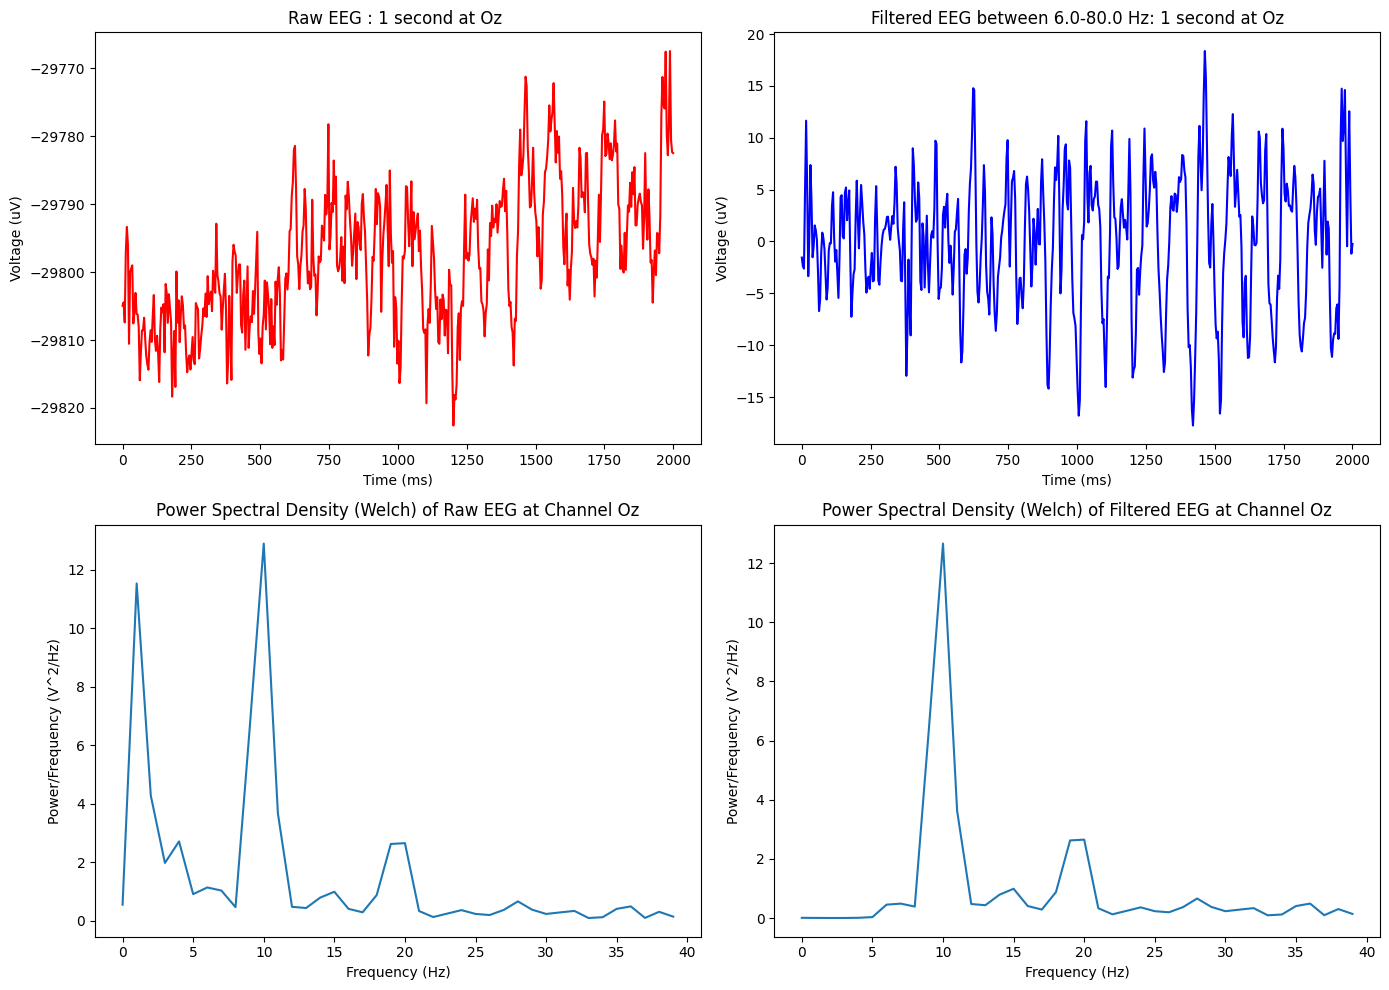

stimulus frequency = 9.75 (Hz)


In [ ]:
import matplotlib.pyplot as plt

samples = sample_epoch.shape[-1]
time = np.linspace(0.0, samples / SAMPLING_RATE, samples) * 1000

freq_to_disp = int(np.where(freqs == 40)[0][0])

# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot temporal data
axes[0, 0].plot(time, sample_epoch[sample_trial, sample_elec, :], "r-")
axes[0, 0].set_xlabel("Time (ms)")
axes[0, 0].set_ylabel("Voltage (uV)")
axes[0, 0].set_title("Raw EEG : 1 second at Oz ")

# Plot filtered temporal data
axes[0, 1].plot(time, sample_epoch_filtered[sample_trial, sample_elec, :], "b-")
axes[0, 1].set_xlabel("Time (ms)")
axes[0, 1].set_ylabel("Voltage (uV)")
axes[0, 1].set_title(f"Filtered EEG between {BANDPASS[0]}-{BANDPASS[1]} Hz: 1 second at Oz")

axes[1, 0].plot(freqs[:freq_to_disp], psd[:freq_to_disp])
axes[1, 0].set_xlabel("Frequency (Hz)")
axes[1, 0].set_ylabel("Power/Frequency (V^2/Hz)")
axes[1, 0].set_title(f"Power Spectral Density (Welch) of Raw EEG at Channel Oz")

axes[1, 1].plot(freqs_filt[:freq_to_disp], psd_filt[:freq_to_disp])
axes[1, 1].set_xlabel("Frequency (Hz)")
axes[1, 1].set_ylabel("Power/Frequency (V^2/Hz)")
axes[1, 1].set_title(f"Power Spectral Density (Welch) of Filtered EEG at Channel Oz")

# Adjust spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

print(f"stimulus frequency = {STIM_FREQS[int(sample_y[sample_trial].squeeze())-1]} (Hz)")

### Why do we get a second peak?

# 5) CCA-Based Decoding

Now that we have prepared and visualized the data, we can move on to the decoding stage.

Canonical Correlation Analysis (CCA) is a classical multivariate statistical method used to uncover relationships between two sets of variables. In essence, CCA finds pairs of linear projections, one for each dataset, such that the correlation between the projected components is maximized.

In the context of SSVEP decoding, these two sets of variables are:

1.	EEG data: each trial is represented as a multichannel time series, where the time samples are observations and the channels are features.

2.	Reference signals: a set of sine and cosine waves at the stimulus frequencies and their harmonics, representing the expected neural entrainment patterns evoked by visual flicker.

By applying CCA, we identify the linear combination of EEG channels that best matches each reference frequency pattern. The stimulus frequency that yields the highest canonical correlation is then selected as the predicted target for that trial.

<figure style="text-align: left;">
  <img src="https://drive.google.com/uc?export=view&id=1YqIYg6A8qg_eqcxx2a3N7Xydok0OZQ-7" width="700">
  <figcaption style="font-size: 0.9em; color: #555; text-align: left; margin-top: 3px;">
    <b>Figure 1.</b> Figure from Lin, Zhonglin, et al. "Frequency recognition based on canonical correlation analysis for SSVEP-based BCIs." IEEE transactions on biomedical engineering 53.12 (2006): 2610-2614.
  </figcaption>
</figure>


## Implement Canonical Correlation Analysis (CCA)

In [ ]:
def generate_reference_signals(freq, phase, fs, samples, harmonics=3):
    """
    Generates sine and cosine waves for a given frequency and phase.

    Args:
        freq: float, frequency in Hz
        phase: float, phase shift in radians
        fs: int, sampling rate
        samples: int, number of samples
        harmonics: int, number of harmonics to include

    Returns:
        ref_signal: np.ndarray, reference signal for a specific frequency shape = (2H, Samples)

    """
    time_vector = np.linspace(0, samples / fs, samples, endpoint=False)
    ref_signal = np.zeros((2*harmonics, samples))
    for h in range(harmonics):
      ref_signal[h*2, :] = np.sin(2 * (h+1) * np.pi * freq * time_vector + phase)
      ref_signal[h*2+1, :] = np.cos(2 * (h+1) * np.pi * freq * time_vector + phase)
    return ref_signal

In [ ]:
from sklearn.cross_decomposition import CCA

def cca_analysis(X, Y):
    """Performs CCA between EEG data and reference signals.

    Args:
        X: EEG data for a single trial (Channels, Samples).
        Y: Reference signals for a single target (2H, Samples).

    Returns:
        The canonical correlation coefficient between the first pair of canonical variates.
    """
    cca = CCA(n_components=1)
    cca.fit(X.T, Y.T)
    X_c, Y_c = cca.transform(X.T, Y.T)
    correlation = np.corrcoef(X_c[:, 0], Y_c[:, 0])[0, 1]
    return correlation

### Load EEG Data

In [ ]:
X, y = load_eeg_epochs(
    DATA_DIR,
    subjects=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    fs=SAMPLING_RATE,
    duration=1.0,
    onset=38,
    delay=0.135,
    band=BANDPASS,
    order=4,
)

X shape: (10, 180, 8, 256)
Y shape: (10, 180, 1)


In [ ]:
# Generate reference signals for all targets
n_samples = X.shape[-1]
reference_signals = []
for freq, phase in zip(STIM_FREQS, PHASES):
    ref = generate_reference_signals(
        freq,
        phase,
        SAMPLING_RATE,
        n_samples,
        harmonics=N_HARMONICS)
    reference_signals.append(ref)

reference_signals = np.array(reference_signals)
print(f"Reference signals shape: {reference_signals.shape} [Targets, 2 x N_HARMONICS, Samples]")

Reference signals shape: (12, 10, 256) [Targets, 2 x N_HARMONICS, Samples]


### Fit CCA to EEG Data

In [ ]:
# Initialize an array to store CCA correlation results
y = y.squeeze()
num_subjects = X.shape[0]
num_trials = X.shape[1]
num_targets = reference_signals.shape[0]
cca_results = np.zeros((num_subjects, num_trials, num_targets))

# Iterate through each subject, trial, and target frequency to perform CCA
for subj_idx in range(num_subjects):
    for trial_idx in range(num_trials):
        for target_idx in range(num_targets):
            eeg_trial_data = X[subj_idx, trial_idx, :, :]  # Channels x Samples
            ref_signal_transposed = reference_signals[target_idx, :, :]  # 2H x Samples
            correlation = cca_analysis(eeg_trial_data, ref_signal_transposed)
            cca_results[subj_idx, trial_idx, target_idx] = correlation

print(f"CCA results shape: {cca_results.shape} [Subject x Trials x Targets]")

CCA results shape: (10, 180, 12) [Subject x Trials x Targets]


In [ ]:
predicted_targets = np.argmax(cca_results, axis=2) + 1
print(f"Predicted target labels shape: {predicted_targets.shape}")

# Calculate accuracy for each subject
subject_accuracies = []
num_subjects = y.shape[0]
num_trials = y.shape[1]

for subj_idx in range(num_subjects):
    correct_predictions = np.sum(predicted_targets[subj_idx, :] == y[subj_idx, :])
    accuracy = correct_predictions / num_trials
    subject_accuracies.append(accuracy)
    print(f"Accuracy for Subject {subj_idx + 1}: {accuracy:.4f}")

# Calculate average accuracy
average_accuracy = np.mean(subject_accuracies)
print(f"\nAverage Accuracy across all subjects: {average_accuracy:.4f}")

Predicted target labels shape: (10, 180)
Accuracy for Subject 1: 0.2611
Accuracy for Subject 2: 0.2444
Accuracy for Subject 3: 0.3278
Accuracy for Subject 4: 0.7611
Accuracy for Subject 5: 0.6778
Accuracy for Subject 6: 0.7444
Accuracy for Subject 7: 0.5833
Accuracy for Subject 8: 0.9000
Accuracy for Subject 9: 0.5833
Accuracy for Subject 10: 0.5333

Average Accuracy across all subjects: 0.5617


### Cross-validation: Do we need it here?

In most machine-learning pipelines, cross-validation (CV) is used to evaluate how well a model generalizes to unseen data. By splitting the dataset into training and testing subsets, we can estimate performance while avoiding overfitting to specific examples.

However, in our SSVEP decoding setup with CCA, we do not need cross-validation for the following reasons:

**No learnable parameters:**
Canonical Correlation Analysis (CCA) is applied independently for each trial and each target frequency. It computes closed-form correlations without training weights or fitting parameters across trials.

**Trial-wise decision rule:**
Each test trial is decoded by comparing its correlation with reference signals directly, so every trial is effectively evaluated independently.

**No hyperparameter tuning:**
We are not adjusting any model parameters (e.g., filter lengths, regularization constants) based on performance metrics, so there is no risk of overfitting through parameter optimization.

**Question:** When is cross-validation necessary in this setup?

# 6) Training with EEGNet

In the final part of this tutorial, we will explore how a deep neural network can be used to decode SSVEP responses. Specifically, we will train a classifier to recognize which of the 12 stimulus targets a participant was looking at, based on their EEG signal.

We will use the EEGNet architecture [2], a compact convolutional neural network specifically designed for EEG decoding tasks. EEGNet introduces a biologically and statistically motivated approach through a combination of:

- Temporal convolutions, which act as band-pass filters to extract frequency-specific features.
- Spatial convolutions, which learn spatial filters across electrodes, similar to what CSP or CCA achieve analytically.

In this section, we will:

1. Prepare the data in a format suitable for neural network input.

2.	Define and train the EEGNet model using PyTorch.

3.	Evaluate its classification accuracy across the 12 target frequencies.

![eegnet.png](https://content.cld.iop.org/journals/1741-2552/15/5/056013/revision2/jneaace8cf01_hr.jpg)


[2] Lawhern, Vernon J., et al. "EEGNet: a compact convolutional neural network for EEG-based brain–computer interfaces." Journal of neural engineering 15.5 (2018): 056013.

### Implemeting EEGNet

In [ ]:
import torch
import torch.nn as nn

class EEGNet(nn.Module):
    def __init__(self, num_channels, num_samples, num_classes):
        super(EEGNet, self).__init__()
        self.firstconv = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=(1, 51), stride=(1, 1), padding=(0, 25), bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True)
        )

        self.depthwiseconv = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=(num_channels, 1), stride=(1, 1), groups=16, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True)
        )

        self.separableconv = nn.Sequential(
            nn.Conv2d(32, 32, kernel_size=(1, 15), stride=(1, 1), padding=(0, 7), bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True)
        )

        self.avgpool = nn.AvgPool2d(kernel_size=(1, 4), stride=(1, 4), padding=0)
        self.dropout = nn.Dropout(p=0.25)
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(32 * (num_samples // 4), num_classes)

    def forward(self, x):
        x = x.unsqueeze(1)
        x = self.firstconv(x)
        x = self.depthwiseconv(x)
        x = self.separableconv(x)
        x = self.avgpool(x)
        x = self.dropout(x)
        x = self.flatten(x)
        x = self.fc(x)
        return x

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import StratifiedKFold
import numpy as np
import copy
import time

#### Data preparation for NN training

In [ ]:
def create_dataloader(X, y, batch_size, shuffle=False):
    """Creates a PyTorch DataLoader from numpy arrays."""
    # Convert numpy arrays to PyTorch tensors
    X_tensor = torch.tensor(X, dtype=torch.float32)
    # Ensure labels are long type for CrossEntropyLoss
    y_tensor = torch.tensor(y, dtype=torch.long)

    dataset = TensorDataset(X_tensor, y_tensor)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)
    return loader


#### Helper functions for training

In [ ]:
# Helper functions for training

def evaluate_model(model, data_loader, criterion, device):
    """Evaluates the model on the given data loader."""
    model.eval()
    total_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)

            # Calculate loss (assuming labels are 1-indexed, so we shift to 0-indexed)
            loss = criterion(outputs, labels - 1)
            total_loss += loss.item() * inputs.size(0)

            # Get predictions
            _, predicted = torch.max(outputs.data, 1)
            # Shift predictions back to 1-indexed for comparison
            predicted += 1

            total_samples += labels.size(0)
            correct_predictions += (predicted == labels).sum().item()

    avg_loss = total_loss / total_samples
    accuracy = correct_predictions / total_samples
    return avg_loss, accuracy

def run_inner_fold_training(train_loader, val_loader, model_class, model_params, criterion, learning_rate, num_epochs, device):
    """
    Trains and validates a single model for an inner fold.
    Returns the final validation loss, accuracy, and the trained model.
    """
    # Instantiate a new model for this fold
    model = model_class(**model_params).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # Training loop
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            # Adjust labels to be 0-indexed for the loss function
            loss = criterion(outputs, labels - 1)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)
        # Optional: Add a verbose flag to control this print
        # print(f"      Epoch [{epoch+1}/{num_epochs}], Inner Train Loss: {epoch_loss:.4f}")

    # Evaluate on the validation set after all epochs
    val_loss, val_accuracy = evaluate_model(model, val_loader, criterion, device)

    return val_loss, val_accuracy, model

The following code implements the main training loop using nested cross-validation to train and evaluate the model. The dataset is divided into N folds, with one fold reserved for testing and the remaining folds used for training. The training portion is then further split into K folds, with one fold serving as validation and the others for training. This process is repeated so that each outer fold is used once as the test set and each inner fold is used once as the validation set.

In [ ]:
def train_one_subject(
    X_data,
    Y_data,
    model_class,
    model_params,
    n_splits_outer=5,
    n_splits_inner=5,
    num_epochs=20,
    batch_size=32,
    learning_rate=0.001,
    random_state=42
):
    """
    Performs nested cross-validation for a single subject's data.

    Args:
        X_data (np.array): Feature data for the subject.
        Y_data (np.array): Label data for the subject (assumed 1-indexed).
        model_class (nn.Module): The model class to instantiate (e.g., EEGNet).
        model_params (dict): Dictionary of parameters to pass to the model constructor
                             (e.g., {'num_channels': 64, 'num_samples': 151, 'num_classes': 12}).
        n_splits_outer (int): Number of folds for the outer loop (testing).
        n_splits_inner (int): Number of folds for the inner loop (validation/model selection).
        num_epochs (int): Number of training epochs for each inner fold model.
        batch_size (int): Batch size for DataLoaders.
        learning_rate (float): Learning rate for the Adam optimizer.
        random_state (int): Random state for StratifiedKFold for reproducibility.

    Returns:
        tuple: (list_of_accuracies, mean_accuracy, std_accuracy)
               A list of test accuracies from each outer fold, the mean, and the std dev.
    """

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Starting Nested CV on {device}...")

    kf_outer = StratifiedKFold(n_splits=n_splits_outer, shuffle=True, random_state=random_state)
    criterion = nn.CrossEntropyLoss()

    outer_fold_accuracies = []

    # --- Outer Loop (Test Split) ---
    for outer_fold, (outer_train_idx, outer_test_idx) in enumerate(kf_outer.split(X_data, Y_data)):
        print(f"\n--- Outer Fold {outer_fold + 1}/{n_splits_outer} ---")
        start_time = time.time()

        # 1. Split data for this outer fold
        X_outer_train = X_data[outer_train_idx]
        Y_outer_train = Y_data[outer_train_idx]
        X_outer_test = X_data[outer_test_idx]
        Y_outer_test = Y_data[outer_test_idx]

        # 2. Prepare inner cross-validation
        kf_inner = StratifiedKFold(n_splits=n_splits_inner, shuffle=True, random_state=random_state)

        best_inner_model_state = None
        lowest_val_loss = float('inf')

        print(f"  Starting Inner {n_splits_inner}-Fold CV for model selection...")

        # --- Inner Loop (Validation/Model Selection Split) ---
        for inner_fold, (inner_train_idx, inner_val_idx) in enumerate(kf_inner.split(X_outer_train, Y_outer_train)):
            # print(f"    Inner Fold {inner_fold + 1}/{n_splits_inner}")

            # 3. Split data for this inner fold
            X_inner_train = X_outer_train[inner_train_idx]
            Y_inner_train = Y_outer_train[inner_train_idx]
            X_inner_val = X_outer_train[inner_val_idx]
            Y_inner_val = Y_outer_train[inner_val_idx]

            # 4. Create DataLoaders
            train_loader = create_dataloader(X_inner_train, Y_inner_train, batch_size, shuffle=True)
            val_loader = create_dataloader(X_inner_val, Y_inner_val, batch_size, shuffle=False)

            # 5. Train a new model and evaluate it
            final_val_loss, final_val_acc, trained_model = run_inner_fold_training(
                train_loader,
                val_loader,
                model_class,
                model_params,
                criterion,
                learning_rate,
                num_epochs,
                device
            )

            # 6. Check if this model is the best one *so far* in this inner loop
            if final_val_loss < lowest_val_loss:
                lowest_val_loss = final_val_loss
                # Save the model's state dictionary
                best_inner_model_state = copy.deepcopy(trained_model.state_dict())
                # print(f"    New best model found! Val Loss: {lowest_val_loss:.4f}, Val Acc: {final_val_acc:.4f}")

        print(f"  Inner CV complete. Best model Val Loss: {lowest_val_loss:.4f}")

        # 7. We now have the best model state from the inner loop.
        # Load it and test it on the *outer test set*.

        # Instantiate a new model instance
        best_model = model_class(**model_params).to(device)
        # Load the best state
        best_model.load_state_dict(best_inner_model_state)

        # 8. Create the outer test dataloader
        test_loader = create_dataloader(X_outer_test, Y_outer_test, batch_size, shuffle=False)

        # 9. Evaluate on the test set
        test_loss, test_accuracy = evaluate_model(best_model, test_loader, criterion, device)

        fold_time = time.time() - start_time
        print(f"--- Outer Fold {outer_fold + 1} Test Results (Took {fold_time:.2f}s) ---")
        print(f"  Test Loss: {test_loss:.4f}")
        print(f"  Test Accuracy: {test_accuracy:.4f}")
        print("------------------------------------------")

        outer_fold_accuracies.append(test_accuracy)

    # --- All Outer Folds Complete ---
    mean_accuracy = np.mean(outer_fold_accuracies)
    std_accuracy = np.std(outer_fold_accuracies)

    print("\n=== Nested Cross-Validation Complete ===")
    print(f"Test Accuracies per fold: {[f'{acc:.4f}' for acc in outer_fold_accuracies]}")
    print(f"Mean Test Accuracy: {mean_accuracy:.4f} +/- {std_accuracy:.4f}")

    return outer_fold_accuracies, mean_accuracy, std_accuracy

### Train the model on a sample subject

In [ ]:
N_SPLITS_OUTER = 5
N_SPLITS_INNER = 5
NUM_EPOCHS = 15
BATCH_SIZE = 16
LEARNING_RATE = 0.001
RANDOM_STATE = 42

num_channels = X.shape[-2]
num_samples = X.shape[-1]
num_classes = 12

model_params = {
    'num_channels': num_channels,
    'num_samples': num_samples,
    'num_classes': num_classes
}

X_subj = X[7, :, :, :]
y_subj = y[7]

print(X_subj.shape)
print(y_subj.shape)

outer_fold_accuracies, mean_accuracy, std_accuracy = train_one_subject(
        X_data=X_subj,
        Y_data=y_subj,
        model_class=EEGNet, # Pass the class, not an instance
        model_params=model_params,
        n_splits_outer=N_SPLITS_OUTER,
        n_splits_inner=N_SPLITS_INNER,
        num_epochs=NUM_EPOCHS,
        batch_size=BATCH_SIZE,
        learning_rate=LEARNING_RATE,
        random_state=RANDOM_STATE
    )

### Train the model per subject for all 10 subjects

In [ ]:
N_SPLITS_OUTER = 5
N_SPLITS_INNER = 5
NUM_EPOCHS = 15
BATCH_SIZE = 16
LEARNING_RATE = 0.001
RANDOM_STATE = 42

num_channels = X.shape[-2]
num_samples = X.shape[-1]
num_classes = 12

model_params = {
    'num_channels': num_channels,
    'num_samples': num_samples,
    'num_classes': num_classes
}

subject_results = {}

for subj in range(1, 11):
  X_subj = X[subj-1, :, :, :]
  y_subj = y[subj-1]

  print(X_subj.shape)
  print(y_subj.shape)

  outer_fold_accuracies, mean_accuracy, std_accuracy = train_one_subject(
          X_data=X_subj,
          Y_data=y_subj,
          model_class=EEGNet, # Pass the class, not an instance
          model_params=model_params,
          n_splits_outer=N_SPLITS_OUTER,
          n_splits_inner=N_SPLITS_INNER,
          num_epochs=NUM_EPOCHS,
          batch_size=BATCH_SIZE,
          learning_rate=LEARNING_RATE,
          random_state=RANDOM_STATE
      )
  subject_results[str(subj)] = {
      'outer_fold_accuracies': outer_fold_accuracies,
      'mean_accuracy': mean_accuracy,
      'std_accuracy': std_accuracy
  }

(180, 8, 256)
(180,)
Starting Nested CV on cuda...

--- Outer Fold 1/5 ---
  Starting Inner 5-Fold CV for model selection...
  Inner CV complete. Best model Val Loss: 0.8185
--- Outer Fold 1 Test Results (Took 7.73s) ---
  Test Loss: 0.8294
  Test Accuracy: 0.8611
------------------------------------------

--- Outer Fold 2/5 ---
  Starting Inner 5-Fold CV for model selection...
  Inner CV complete. Best model Val Loss: 0.7403
--- Outer Fold 2 Test Results (Took 3.90s) ---
  Test Loss: 0.9027
  Test Accuracy: 0.7222
------------------------------------------

--- Outer Fold 3/5 ---
  Starting Inner 5-Fold CV for model selection...
  Inner CV complete. Best model Val Loss: 0.8020
--- Outer Fold 3 Test Results (Took 2.04s) ---
  Test Loss: 0.7380
  Test Accuracy: 0.8611
------------------------------------------

--- Outer Fold 4/5 ---
  Starting Inner 5-Fold CV for model selection...
  Inner CV complete. Best model Val Loss: 0.9939
--- Outer Fold 4 Test Results (Took 1.47s) ---
  Test L

### Compare Model Performances

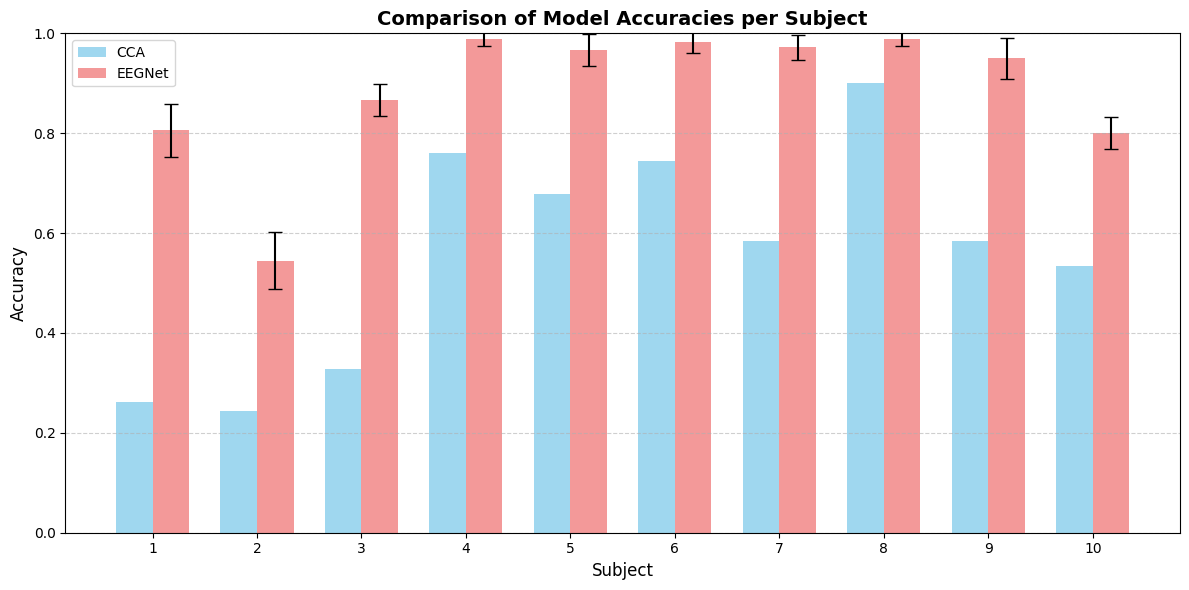

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Example data structure
# subject_accuracies = [0.75, 0.80, 0.65, ...]  # CCA accuracies
# subject_results = {
#     '1': {'mean_accuracy': 0.78, 'std_accuracy': 0.05},
#     '2': {'mean_accuracy': 0.83, 'std_accuracy': 0.04},
#     ...
# }

# Convert subject keys to sorted numeric order
subjects = sorted([int(k) for k in subject_results.keys()])
subjects_str = [str(s) for s in subjects]

# Extract EEGNet mean and std accuracies in the same order
eegnet_means = [subject_results[str(s)]['mean_accuracy'] for s in subjects]
eegnet_stds = [subject_results[str(s)]['std_accuracy'] for s in subjects]

# Make sure CCA list matches same order and length
cca_accs = [subject_accuracies[s - 1] for s in subjects]

# Bar positions
x = np.arange(len(subjects))
width = 0.35  # width of each bar

# Plot
fig, ax = plt.subplots(figsize=(12, 6))

bars1 = ax.bar(x - width/2, cca_accs, width, label='CCA', color='skyblue', alpha=0.8)
bars2 = ax.bar(x + width/2, eegnet_means, width, yerr=eegnet_stds,
               label='EEGNet', color='lightcoral', alpha=0.8, capsize=5)

# Labels and styling
ax.set_xlabel('Subject', fontsize=12)
ax.set_ylabel('Accuracy', fontsize=12)
ax.set_title('Comparison of Model Accuracies per Subject', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(subjects_str)
ax.set_ylim(0, 1.0)
ax.legend()

ax.grid(axis='y', linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()